In [40]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scib
import utils

import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [41]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

### Loading data and building Anndata object

In [42]:
counts = '/home/d/danilina/masterprak/data/GSE141259_WholeLung_rawcounts.mtx'
annotation = '/home/d/danilina/masterprak/data/GSE141259_WholeLung_cellinfo.csv'
genes = '/home/d/danilina/masterprak/data/GSE141259_WholeLung_genes.txt'

In [43]:
adata = sc.read_mtx(counts).transpose()
adata.obs = pd.read_csv(annotation)
adata.var = pd.read_csv(genes, header=None)
adata.var_names = adata.var[0]
adata.var.rename(columns={0: "gene_name"}, inplace=True)

In [44]:
adata.obs_names = adata.obs.index
adata

AnnData object with n_obs × n_vars = 29297 × 23400
    obs: 'Unnamed: 0', 'nGene', 'nUMI', 'orig.ident', 'identifier', 'res.2', 'grouping', 'cell.type', 'metacelltype', 'spline_cluster'
    var: 'gene_name'

In [45]:
adata.layers["raw_counts"] = adata.X.copy()

### Quality control

In [46]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^Hb[^(p)]"))

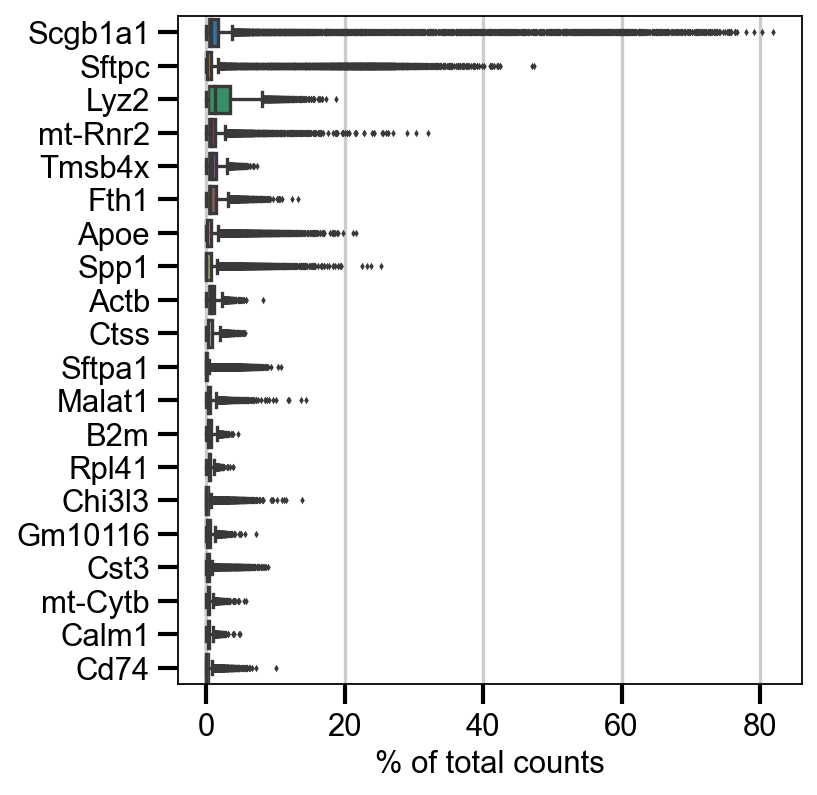

In [47]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [48]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 29297 × 23400
    obs: 'Unnamed: 0', 'nGene', 'nUMI', 'orig.ident', 'identifier', 'res.2', 'grouping', 'cell.type', 'metacelltype', 'spline_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_name', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts'

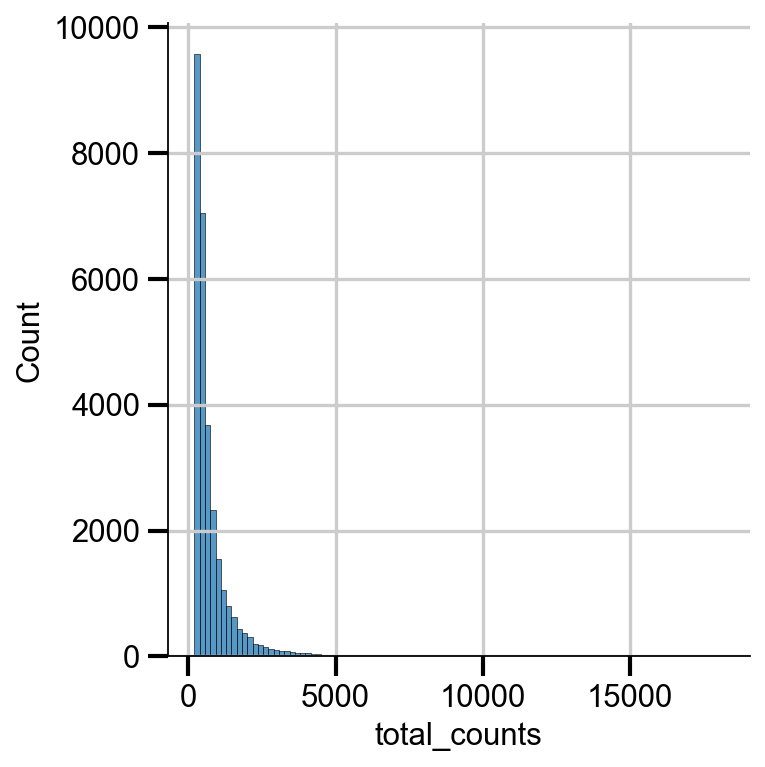

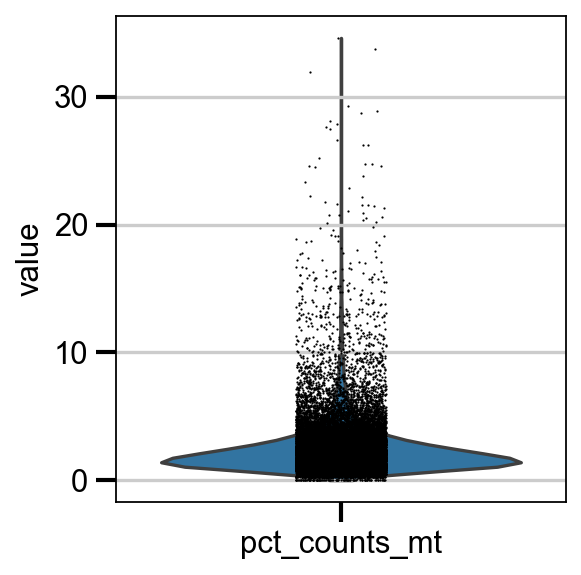

/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_utils.py:743: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = pl.colorbar(


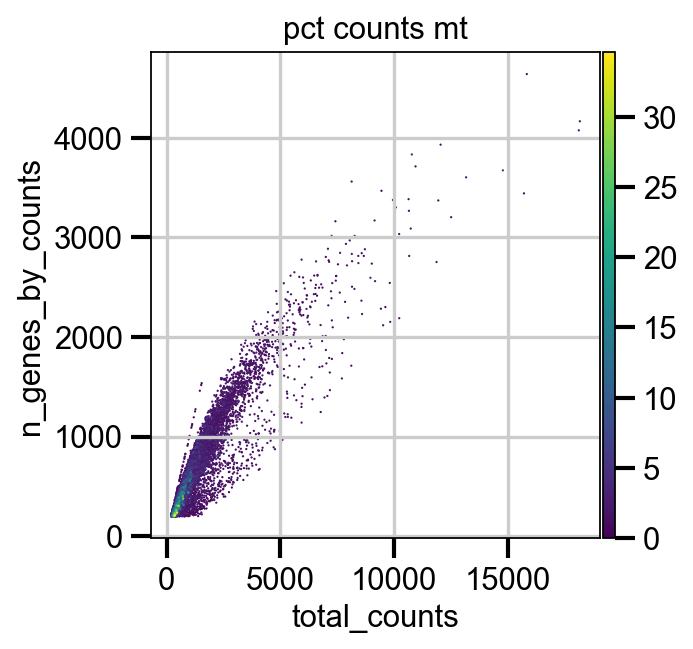

In [49]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

automatic thresholding and filtering based on MAD, as in best practices

In [50]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    27228
True      2069
Name: count, dtype: int64

In [51]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    26051
True      3246
Name: count, dtype: int64

In [52]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 29297
Number of cells after filtering of low quality cells: 24071


/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_utils.py:743: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = pl.colorbar(


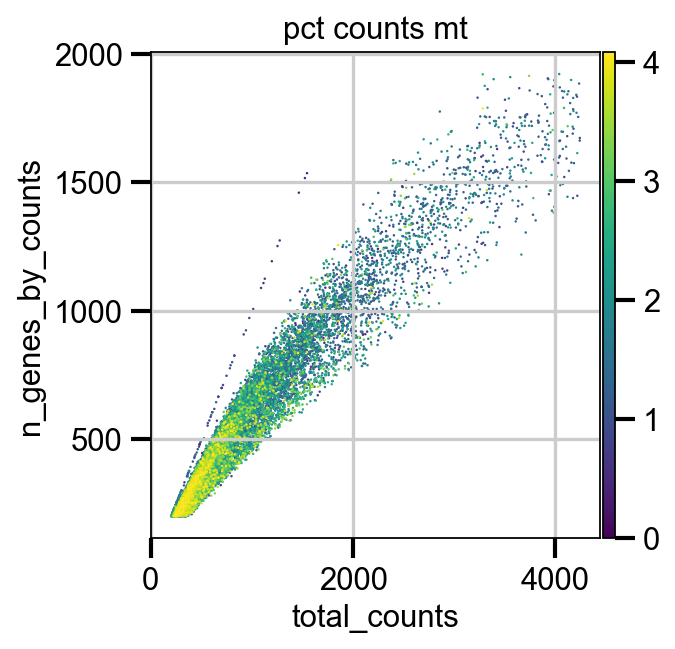

In [53]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

#### Doublet detection

In [54]:
sc.external.pp.scrublet(adata)

/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.72
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.4%


In [55]:
adata.obs["is_doublet"] = adata.obs["doublet_score"] > 0.5

In [56]:
adata.obs

,Unnamed: 0,nGene,nUMI,orig.ident,identifier,res.2,grouping,cell.type,metacelltype,spline_cluster,...,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,outlier,mt_outlier,doublet_score,predicted_doublet,is_doublet
0,muc4169_PBS_d14:muc4169_PBS_d14:CCATCCCGCCCG,288,366,muc4169,muc4169_PBS_d14,5,PBS,T-lymphocytes,T_cells,t_cells,...,3.737670,11.202186,0.0,0.0,0.0,False,False,0.131287,False,False
1,muc4169_PBS_d14:muc4169_PBS_d14:ATCACCTATGCG,784,1429,muc4169,muc4169_PBS_d14,1,PBS,AT2 cells,alv_epithelium,alv_epithelium,...,4.499810,6.228131,0.0,0.0,0.0,False,False,0.040942,False,False
2,muc4169_PBS_d14:muc4169_PBS_d14:CGCACCGACCAC,333,437,muc4169,muc4169_PBS_d14,13,PBS,VECs,endothelial_cells,vec,...,3.135494,5.034325,0.0,0.0,0.0,False,False,0.040942,False,False
3,muc4169_PBS_d14:muc4169_PBS_d14:TCCTACTGGCAC,255,421,muc4169,muc4169_PBS_d14,1,PBS,AT2 cells,alv_epithelium,alv_epithelium,...,2.833213,3.800475,0.0,0.0,0.0,False,False,0.038234,False,False
4,muc4169_PBS_d14:muc4169_PBS_d14:CCGGAAACGCGA,389,516,muc4169,muc4169_PBS_d14,5,PBS,T-lymphocytes,T_cells,t_cells,...,4.143135,12.015504,0.0,0.0,0.0,False,False,0.022087,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29291,muc4657_PBS_d21:muc4657_PBS_d21:CGGGTCTCATCT,698,976,muc4657,muc4657_PBS_d21,11,PBS,Ciliated cells,ciliated_cells,ciliated_cells,...,3.135494,2.254098,0.0,0.0,0.0,False,False,0.023217,False,False
29292,muc4657_PBS_d21:muc4657_PBS_d21:ATCAAGACAGTG,340,670,muc4657,muc4657_PBS_d21,1,PBS,AT2 cells,alv_epithelium,alv_epithelium,...,3.433987,4.477612,0.0,0.0,0.0,False,False,0.017725,False,False
29293,muc4657_PBS_d21:muc4657_PBS_d21:GACTGCGCATGG,223,263,muc4657,muc4657_PBS_d21,11,PBS,Ciliated cells,ciliated_cells,ciliated_cells,...,2.079442,2.661597,0.0,0.0,0.0,False,False,0.015406,False,False
29294,muc4657_PBS_d21:muc4657_PBS_d21:ATGACCGAATGT,240,436,muc4657,muc4657_PBS_d21,1,PBS,AT2 cells,alv_epithelium,alv_epithelium,...,2.772589,3.440367,0.0,0.0,0.0,False,False,0.037590,False,False


In [57]:
print("Doublets according to automatic threshold: ", sum(adata.obs["predicted_doublet"]))
print("Doublets with score greater than 0.5: ", sum(adata.obs["is_doublet"]))

Doublets according to automatic threshold:  1
Doublets with score greater than 0.5:  12


Likely many doublets were filtered out based on total counts alone.

### Normalization

In [58]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
adata.X = adata.layers["log1p_norm"]

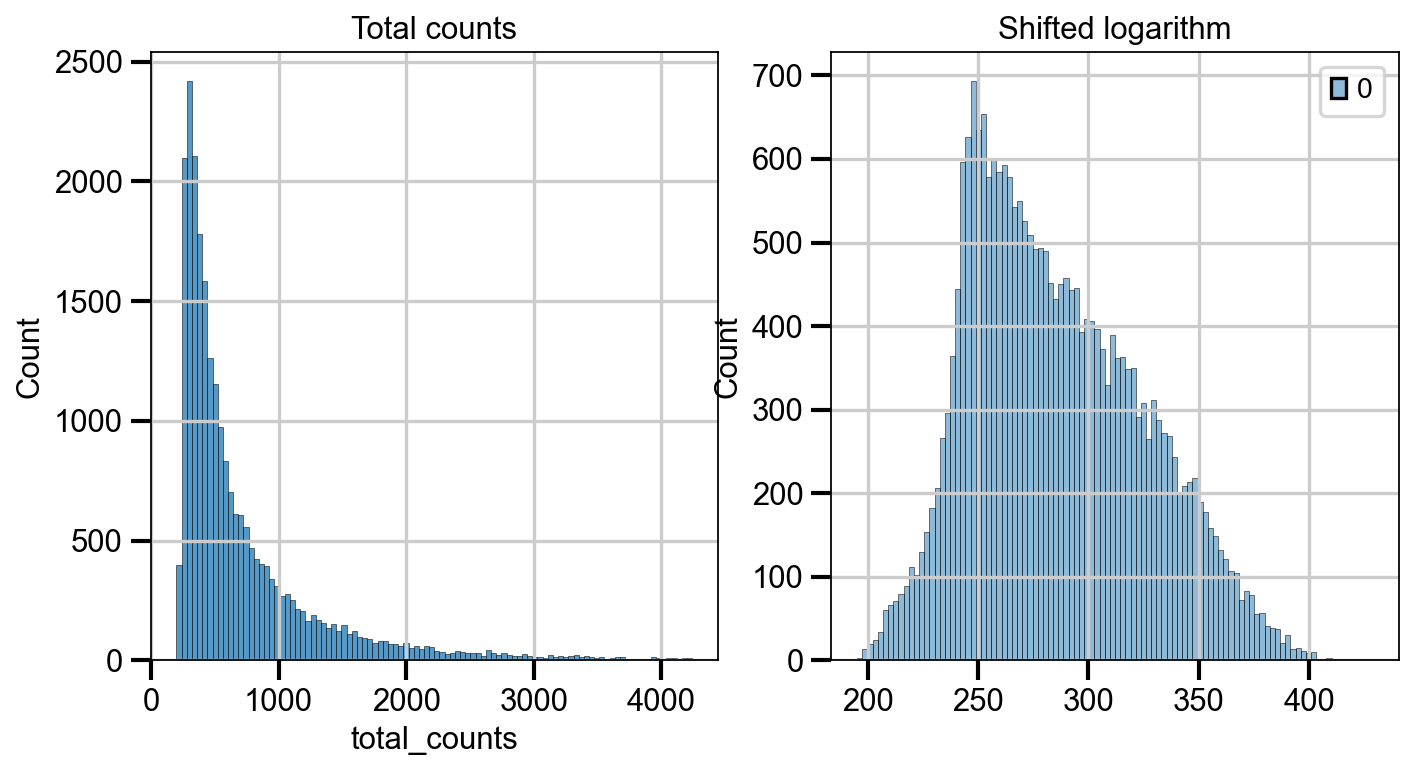

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

### Feature selection using highly-variable genes

In [60]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

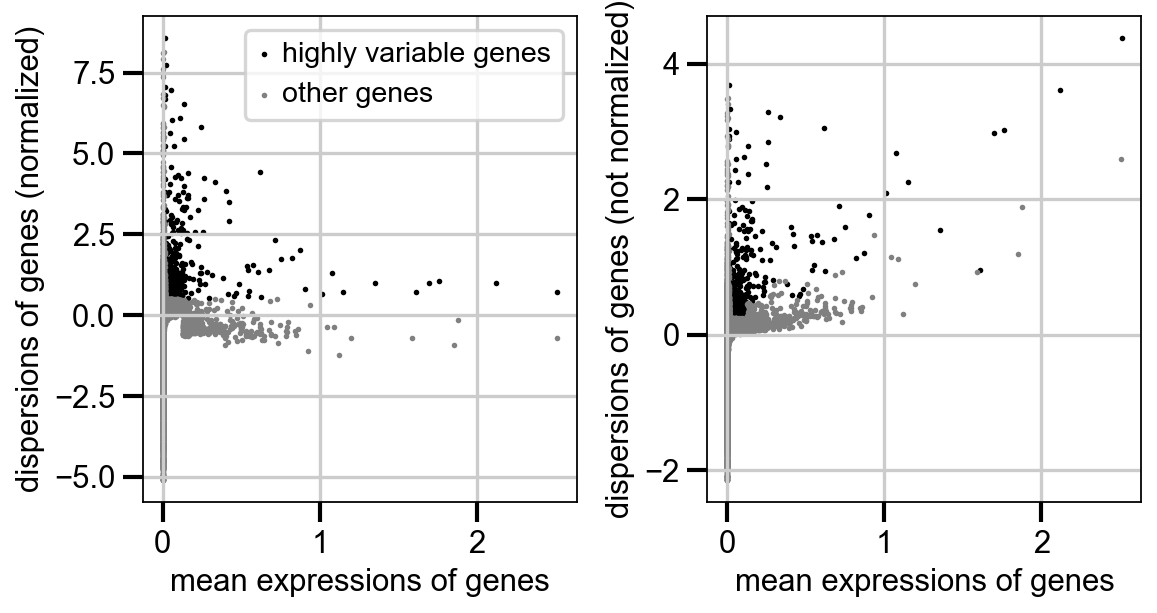

In [61]:
sc.pl.highly_variable_genes(adata)

In [62]:
adata

AnnData object with n_obs × n_vars = 24071 × 23400
    obs: 'Unnamed: 0', 'nGene', 'nUMI', 'orig.ident', 'identifier', 'res.2', 'grouping', 'cell.type', 'metacelltype', 'spline_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet', 'is_doublet'
    var: 'gene_name', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scrublet', 'hvg'
    layers: 'raw_counts', 'log1p_norm'

### Dimentionality reduction

In [63]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)

/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


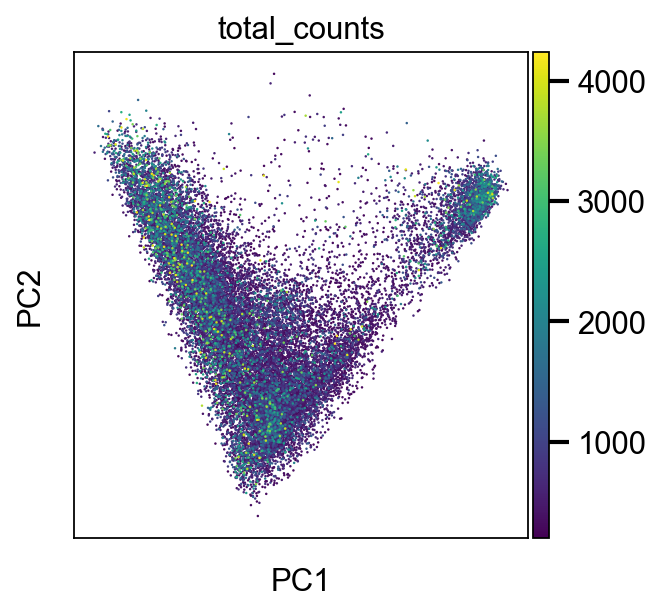

In [64]:
sc.pl.pca_scatter(adata, color="total_counts")

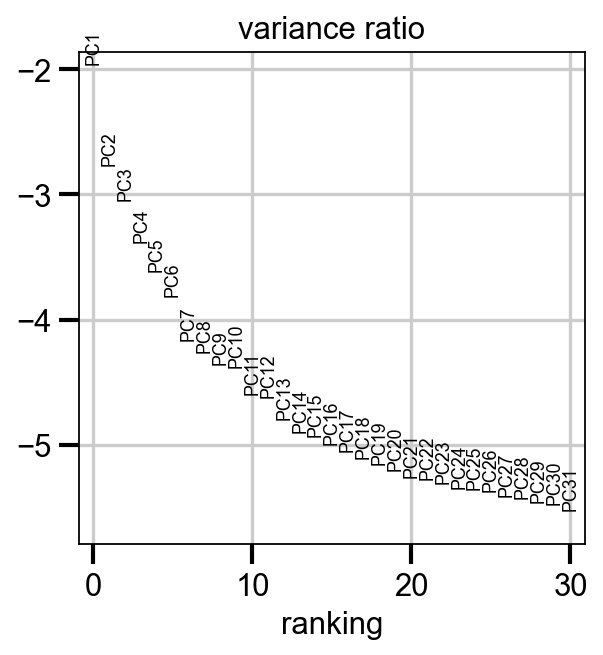

In [65]:
sc.pl.pca_variance_ratio(adata, log=True)

In [66]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


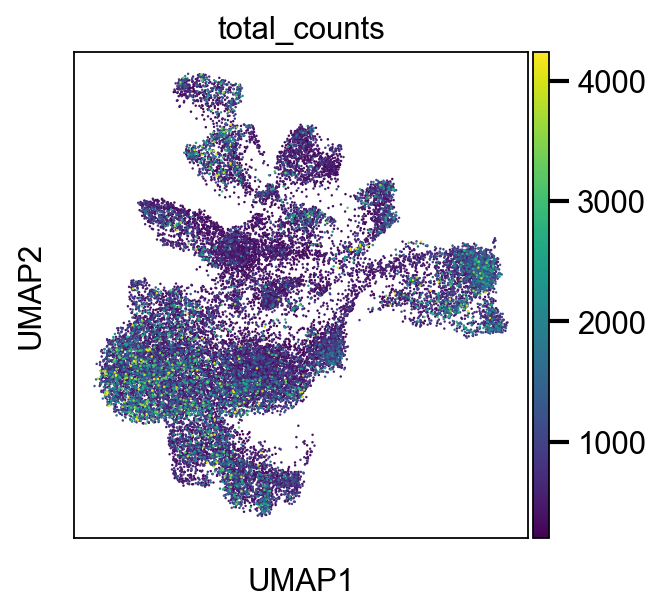

In [67]:
sc.pl.umap(adata, color="total_counts")

visualize QC metrics on the UMAP:

/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


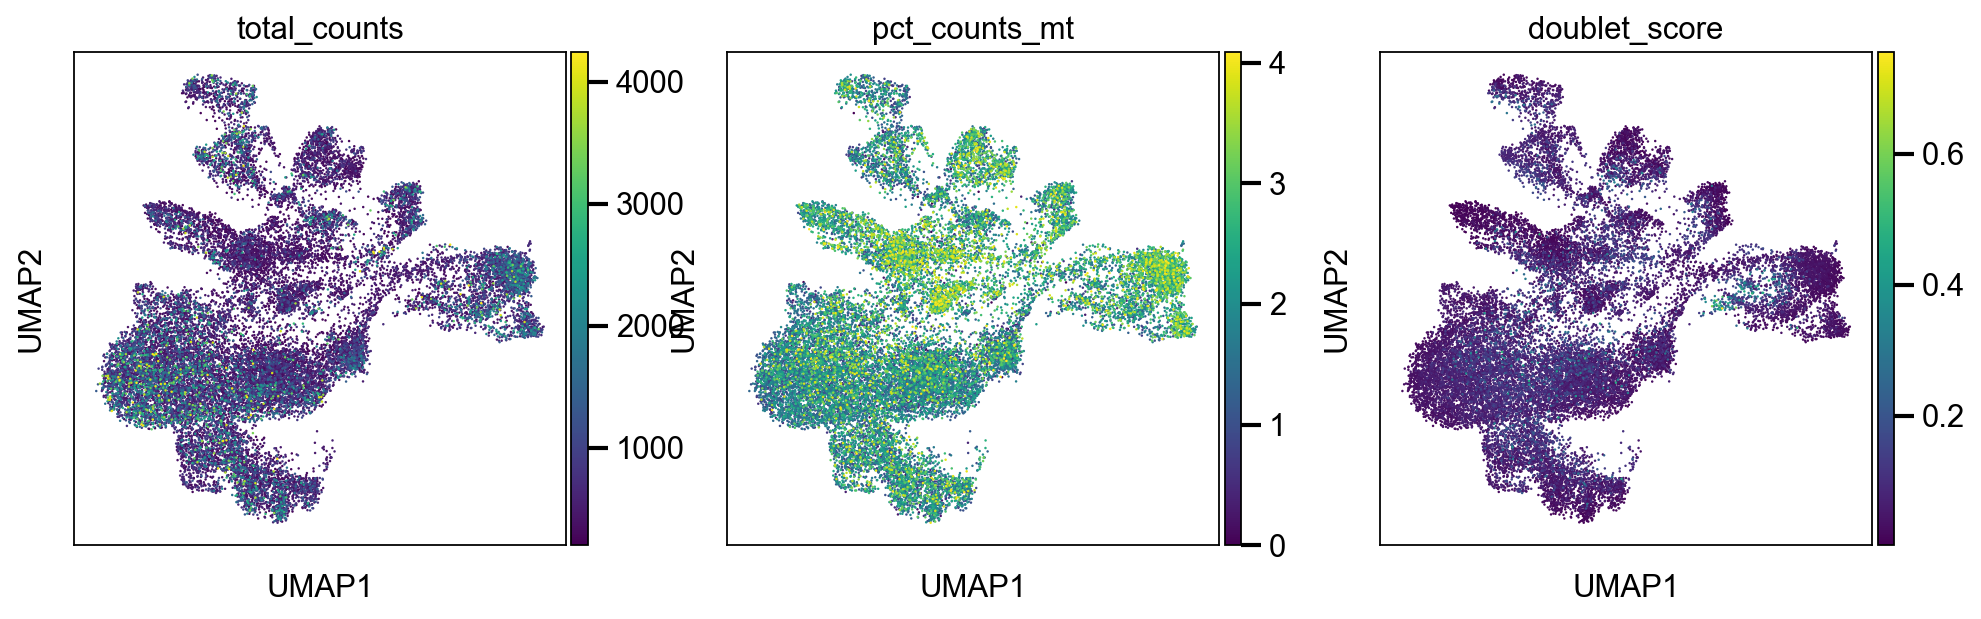

In [68]:
sc.pl.umap(adata, color=["total_counts", "pct_counts_mt", "doublet_score"])

/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


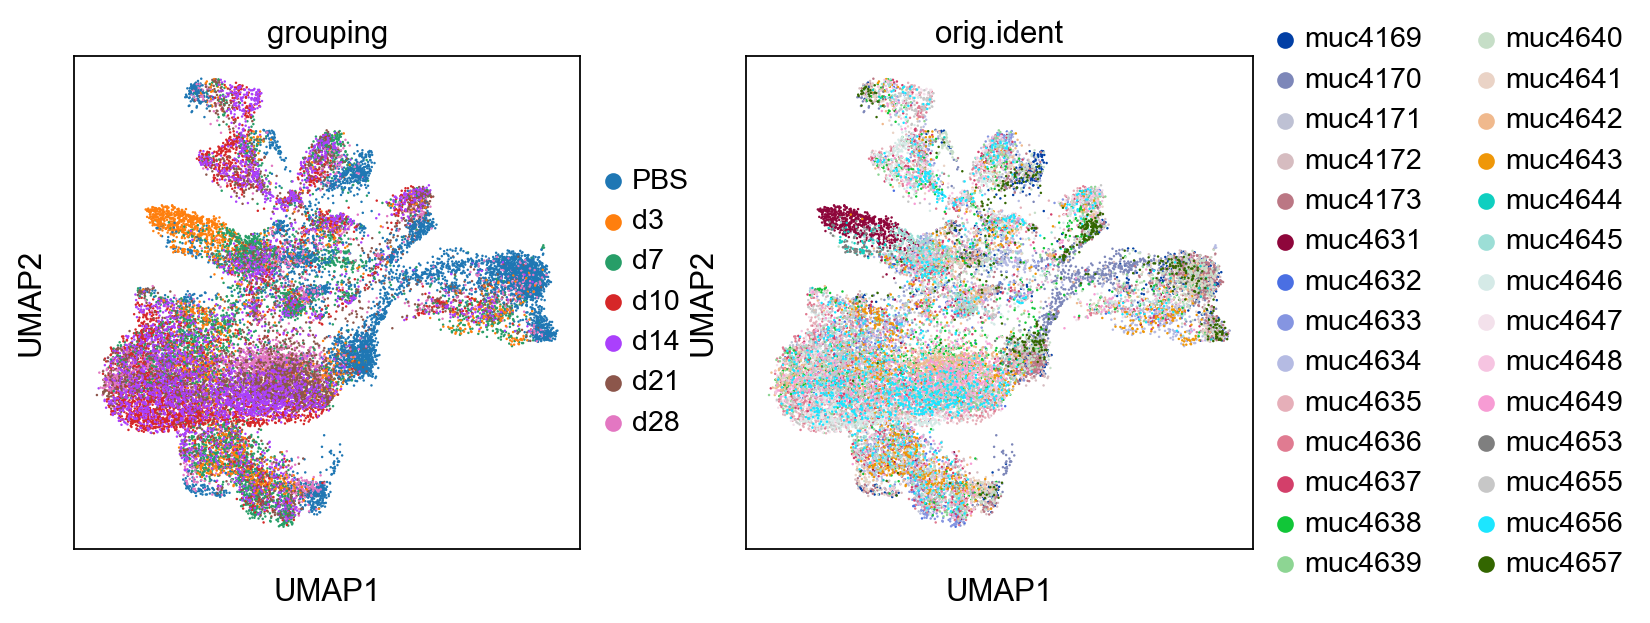

In [69]:
sc.pl.umap(adata, color=["grouping", "orig.ident"])

In [70]:
adata

AnnData object with n_obs × n_vars = 24071 × 23400
    obs: 'Unnamed: 0', 'nGene', 'nUMI', 'orig.ident', 'identifier', 'res.2', 'grouping', 'cell.type', 'metacelltype', 'spline_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet', 'is_doublet'
    var: 'gene_name', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scrublet', 'hvg', 'pca', 'neighbors', 'umap', 'grouping_colors', 'orig.ident_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'log1p_norm'
    obsp: 'distances', 'connec

In [71]:
adata.obs

,Unnamed: 0,nGene,nUMI,orig.ident,identifier,res.2,grouping,cell.type,metacelltype,spline_cluster,...,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,outlier,mt_outlier,doublet_score,predicted_doublet,is_doublet
0,muc4169_PBS_d14:muc4169_PBS_d14:CCATCCCGCCCG,288,366,muc4169,muc4169_PBS_d14,5,PBS,T-lymphocytes,T_cells,t_cells,...,3.737670,11.202186,0.0,0.0,0.0,False,False,0.131287,False,False
1,muc4169_PBS_d14:muc4169_PBS_d14:ATCACCTATGCG,784,1429,muc4169,muc4169_PBS_d14,1,PBS,AT2 cells,alv_epithelium,alv_epithelium,...,4.499810,6.228131,0.0,0.0,0.0,False,False,0.040942,False,False
2,muc4169_PBS_d14:muc4169_PBS_d14:CGCACCGACCAC,333,437,muc4169,muc4169_PBS_d14,13,PBS,VECs,endothelial_cells,vec,...,3.135494,5.034325,0.0,0.0,0.0,False,False,0.040942,False,False
3,muc4169_PBS_d14:muc4169_PBS_d14:TCCTACTGGCAC,255,421,muc4169,muc4169_PBS_d14,1,PBS,AT2 cells,alv_epithelium,alv_epithelium,...,2.833213,3.800475,0.0,0.0,0.0,False,False,0.038234,False,False
4,muc4169_PBS_d14:muc4169_PBS_d14:CCGGAAACGCGA,389,516,muc4169,muc4169_PBS_d14,5,PBS,T-lymphocytes,T_cells,t_cells,...,4.143135,12.015504,0.0,0.0,0.0,False,False,0.022087,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29291,muc4657_PBS_d21:muc4657_PBS_d21:CGGGTCTCATCT,698,976,muc4657,muc4657_PBS_d21,11,PBS,Ciliated cells,ciliated_cells,ciliated_cells,...,3.135494,2.254098,0.0,0.0,0.0,False,False,0.023217,False,False
29292,muc4657_PBS_d21:muc4657_PBS_d21:ATCAAGACAGTG,340,670,muc4657,muc4657_PBS_d21,1,PBS,AT2 cells,alv_epithelium,alv_epithelium,...,3.433987,4.477612,0.0,0.0,0.0,False,False,0.017725,False,False
29293,muc4657_PBS_d21:muc4657_PBS_d21:GACTGCGCATGG,223,263,muc4657,muc4657_PBS_d21,11,PBS,Ciliated cells,ciliated_cells,ciliated_cells,...,2.079442,2.661597,0.0,0.0,0.0,False,False,0.015406,False,False
29294,muc4657_PBS_d21:muc4657_PBS_d21:ATGACCGAATGT,240,436,muc4657,muc4657_PBS_d21,1,PBS,AT2 cells,alv_epithelium,alv_epithelium,...,2.772589,3.440367,0.0,0.0,0.0,False,False,0.037590,False,False


In [72]:
adata.write("../../../data/schiller_whl_qc.h5ad")